## Connect to ElasticSearch

In [125]:
from pprint import pprint
from elasticsearch import Elasticsearch

es = Elasticsearch('http://localhost:9200')
client_info = es.info()
print('Connected to Elasticsearch!')
pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'DlYG5m9gR3upn7qgaYyAJA',
 'name': '3d37442d2591',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2024-08-05T10:05:34.233336849Z',
             'build_flavor': 'default',
             'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '9.11.1',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.15.0'}}


## Get documents

In [151]:
count = es.count(index="cpu_example_template")
pprint(count.body)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 2, 'total': 2},
 'count': 3611}


In [127]:
response = es.search(
    index="cpu_example_template",
    body={
        "query": {
            "match_all": {}
        },
        "size": 1000
    },
)
hits = response.body["hits"]["hits"]

## Plot the time series data

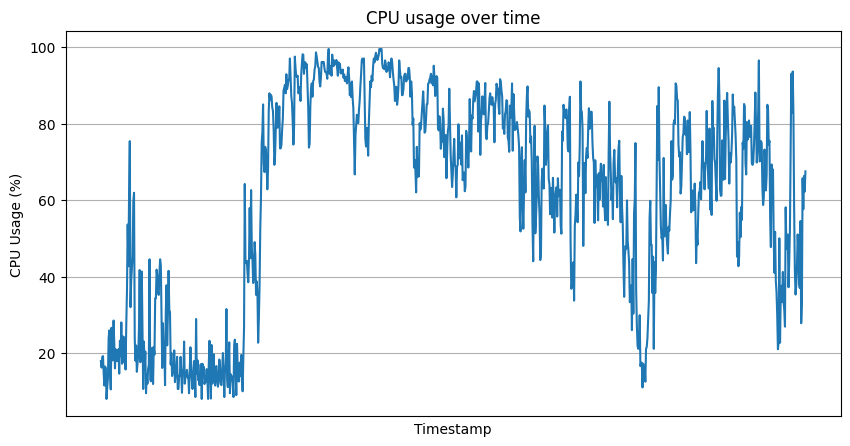

In [128]:
import matplotlib.pyplot as plt

cpu_usage_values = [hit["_source"]["cpu_usage"] for hit in hits]
timestamp_values = [hit["_source"]["@timestamp"] for hit in hits]

plt.figure(figsize=(10, 5))
plt.plot(timestamp_values, cpu_usage_values)
plt.xticks([])
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (%)")
plt.title("CPU usage over time")
plt.grid(True)
plt.show()

## Aggregations

In [129]:
response = es.search(
    index="cpu_example_template",
    body={
        "aggs": {
            "avg_cpu_usage": {
                "avg": {
                    "field": "cpu_usage"
                }
            }
        },
    },
)
average_cpu_usage = response.body["aggregations"]["avg_cpu_usage"]["value"]
print(f"Average CPU usage: {average_cpu_usage}%")

Average CPU usage: 45.16299725035118%


In [130]:
response = es.search(
    index="cpu_example_template",
    body={
        "aggs": {
            "max_cpu_usage": {
                "max": {
                    "field": "cpu_usage"
                }
            }
        },
    },
)
max_cpu_usage = response.body["aggregations"]["max_cpu_usage"]["value"]
print(f"Max CPU usage: {max_cpu_usage}%")

Max CPU usage: 99.5%


## Monitoring the index lifecycle

In [131]:
response = es.indices.get_data_stream()
pprint(response.body)

{'data_streams': [{'_meta': {'description': 'Template for CPU usage data'},
                   'allow_custom_routing': False,
                   'generation': 2,
                   'hidden': False,
                   'ilm_policy': 'cpu_usage_policy_v2',
                   'indices': [{'ilm_policy': 'cpu_usage_policy_v2',
                                'index_name': '.ds-cpu_example_template-2024.11.09-000001',
                                'index_uuid': 'v8_Y_HsjT5aI_ixaRSkMTA',
                                'managed_by': 'Index Lifecycle Management',
                                'prefer_ilm': True},
                               {'ilm_policy': 'cpu_usage_policy_v2',
                                'index_name': '.ds-cpu_example_template-2024.11.09-000002',
                                'index_uuid': 'PPtLqiNXT06bDqbfosUEtw',
                                'managed_by': 'Index Lifecycle Management',
                                'prefer_ilm': True}],
                   'n

In [148]:
ilm_status = es.ilm.get_lifecycle(name="cpu_usage_policy_v2")
pprint(ilm_status.body)

{'cpu_usage_policy_v2': {'in_use_by': {'composable_templates': ['cpu_example_template'],
                                       'data_streams': ['cpu_example_template'],
                                       'indices': ['.ds-cpu_example_template-2024.11.09-000002',
                                                   '.ds-cpu_example_template-2024.11.09-000004']},
                         'modified_date': '2024-11-09T07:04:33.173Z',
                         'policy': {'phases': {'delete': {'actions': {'delete': {'delete_searchable_snapshot': True}},
                                                          'min_age': '20m'},
                                               'hot': {'actions': {'rollover': {'max_age': '5m'}},
                                                       'min_age': '0ms'}}},
                         'version': 1}}


In [150]:
response = es.ilm.explain_lifecycle(
    index=".ds-cpu_example_template*")
pprint(response.body)

{'indices': {'.ds-cpu_example_template-2024.11.09-000002': {'action': 'complete',
                                                            'action_time_millis': 1731138909672,
                                                            'age': '46.34s',
                                                            'index': '.ds-cpu_example_template-2024.11.09-000002',
                                                            'index_creation_date_millis': 1731136509475,
                                                            'lifecycle_date_millis': 1731138909472,
                                                            'managed': True,
                                                            'phase': 'hot',
                                                            'phase_execution': {'modified_date_in_millis': 1731135873173,
                                                                                'phase_definition': {'actions': {'rollover': {'max_age': '5m',
      